In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.api.types import CategoricalDtype
import re
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
months_dtype = CategoricalDtype(categories=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
                                            'Sep','Oct','Nov','Dec'], ordered=True)

In [3]:
# Read CSV with all data from merged-pdfs.ipynb
df = pd.read_csv("finished-csvs/all-data-combined-long-format.csv", 
                 encoding="utf-8", dtype={'Month':months_dtype})
df.head()

Institution                               Subcategory                            Metric Title  Year Month Value
0               ASP                               ASU EOP Hub                       Actual Population  2009   Jan     0
1               ASP                              ASU Overflow                       Actual Population  2009   Jan     0
2               ASP  Academic Programs -\nAttendance Tracking          Average # Days in School (DIS)  2009   Jan    98
3               ASP  Academic Programs -\nAttendance Tracking                Average Daily Attendance  2009   Jan   663
4               ASP  Academic Programs -\nAttendance Tracking  Avg. Length of Time in Assignment(LTA)  2009   Jan   154
...             ...                                       ...                                     ...   ...   ...   ...
3350025         WSP                             Type of Force                             37 mm/40 mm  2023   Oct     2
3350026         WSP                             Type of Force                                   Baton  2023   Oct     1
3350027         WSP                             Type of Force                  Non-Conventional Force  2023   Oct     0
3350028         WSP                             Type of Force                                      OC  2023   Oct     8
3350029         WSP                             Type of Force                          Physical Force  2023   Oct     2

[3350030 rows x 6 columns]

In [4]:
# Filter to only high security prisons (https://www.cdcr.ca.gov/adult-operations/high-security/)
high_security = ["CCI", "COR", "LAC", "SAC", "HDSP", "KVSP", "PBSP", "SVSP"] # omit SATF and CAC
df_highsecurity = df.loc[df['Institution'].isin(high_security)]
df_highsecurity.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1497,CCI,ASU EOP Hub,Actual Population,2009,Jan,0,df_2009_2019_melted
1498,CCI,ASU Overflow,Actual Population,2009,Jan,26,df_2009_2019_melted
1499,CCI,Academic Programs -\nAttendance Tracking,Average # Days in School (DIS),2009,Jan,74,df_2009_2019_melted
1500,CCI,Academic Programs -\nAttendance Tracking,Average Daily Attendance,2009,Jan,280,df_2009_2019_melted
1501,CCI,Academic Programs -\nAttendance Tracking,Avg. Length of Time in Assignment(LTA),2009,Jan,144,df_2009_2019_melted


In [5]:
# Some rows are repeats with errant zero values from COMPSTAT, while incident reports have values.

df_highsecurity[(df_highsecurity['Year'] == 2020) & (df_highsecurity['Metric Title'] == 'Documented Use of Force')]

Institution          Subcategory             Metric Title  Year Month Value
612494         CAC  Number of Incidents  Documented Use of Force  2020   Jan     0
612495         CAC  Number of Incidents  Documented Use of Force  2020   Jan     6
613197         CCI  Number of Incidents  Documented Use of Force  2020   Jan     0
613198         CCI  Number of Incidents  Documented Use of Force  2020   Jan    41
613899         COR  Number of Incidents  Documented Use of Force  2020   Jan     0
613900         COR  Number of Incidents  Documented Use of Force  2020   Jan    26
614608        HDSP  Number of Incidents  Documented Use of Force  2020   Jan     0
614609        HDSP  Number of Incidents  Documented Use of Force  2020   Jan    27
615324        KVSP  Number of Incidents  Documented Use of Force  2020   Jan     0
615325        KVSP  Number of Incidents  Documented Use of Force  2020   Jan    37
616040         LAC  Number of Incidents  Documented Use of Force  2020   Jan     0
616041         LAC  Number of Incidents  Documented Use of Force  2020   Jan    43
616738        PBSP  Number of Incidents  Documented Use of Force  2020   Jan     0
616739        PBSP  Number of Incidents  Documented Use of Force  2020   Jan    24
617451         SAC  Number of Incidents  Documented Use of Force  2020   Jan     0
617452         SAC  Number of Incidents  Documented Use of Force  2020   Jan    57
618167        SVSP  Number of Incidents  Documented Use of Force  2020   Jan     0
618168        SVSP  Number of Incidents  Documented Use of Force  2020   Jan    52
618847         CAC  Number of Incidents  Documented Use of Force  2020   Feb     0
618848         CAC  Number of Incidents  Documented Use of Force  2020   Feb     5
619552         CCI  Number of Incidents  Documented Use of Force  2020   Feb     0
619553         CCI  Number of Incidents  Documented Use of Force  2020   Feb    35
620255         COR  Number of Incidents  Documented Use of Force  2020   Feb     0
620256         COR  Number of Incidents  Documented Use of Force  2020   Feb    24
620962        HDSP  Number of Incidents  Documented Use of Force  2020   Feb     0
620963        HDSP  Number of Incidents  Documented Use of Force  2020   Feb    41
621677        KVSP  Number of Incidents  Documented Use of Force  2020   Feb     0
621678        KVSP  Number of Incidents  Documented Use of Force  2020   Feb    57
622395         LAC  Number of Incidents  Documented Use of Force  2020   Feb     0
622396         LAC  Number of Incidents  Documented Use of Force  2020   Feb    38
623093        PBSP  Number of Incidents  Documented Use of Force  2020   Feb     0
623094        PBSP  Number of Incidents  Documented Use of Force  2020   Feb    27
623808         SAC  Number of Incidents  Documented Use of Force  2020   Feb     0
623809         SAC  Number of Incidents  Documented Use of Force  2020   Feb    62
624524        SVSP  Number of Incidents  Documented Use of Force  2020   Feb     0
624525        SVSP  Number of Incidents  Documented Use of Force  2020   Feb    66
625205         CAC  Number of Incidents  Documented Use of Force  2020   Mar     0
625206         CAC  Number of Incidents  Documented Use of Force  2020   Mar     5
625909         CCI  Number of Incidents  Documented Use of Force  2020   Mar     0
625910         CCI  Number of Incidents  Documented Use of Force  2020   Mar    40
626611         COR  Number of Incidents  Documented Use of Force  2020   Mar     0
626612         COR  Number of Incidents  Documented Use of Force  2020   Mar    23
627318        HDSP  Number of Incidents  Documented Use of Force  2020   Mar     0
627319        HDSP  Number of Incidents  Documented Use of Force  2020   Mar    39
628033        KVSP  Number of Incidents  Documented Use of Force  2020   Mar     0
628034        KVSP  Number of Incidents  Documented Use of Force  2020   Mar    46
628750         LAC  Number of Incidents  Documented Use of Force  2020   Mar     0
628751         LAC  Num

In [6]:
# Remove 2020 Documented Use of Force with zero values from df_2020_2023_POP_no_cat file
indices_of_repeated_zero_value = df_highsecurity[(df_highsecurity['Value'] == '0') & 
                                                 (df_highsecurity['Year'] == 2020) & 
                                                 (df_highsecurity['Metric Title'] == 'Documented Use of Force') &
                                                (df_highsecurity['file'] == 'df_2020_2023_POP_no_cat')].index
df_highsecurity.drop(index=indices_of_repeated_zero_value, inplace=True)

df_highsecurity[(df_highsecurity['Year'] == 2020) & 
                (df_highsecurity['Metric Title'] == 'Documented Use of Force')].head()

,Institution,Subcategory,Metric Title,Year,Month,Value
612495,CAC,Number of Incidents,Documented Use of Force,2020,Jan,6
613198,CCI,Number of Incidents,Documented Use of Force,2020,Jan,41
613900,COR,Number of Incidents,Documented Use of Force,2020,Jan,26
614609,HDSP,Number of Incidents,Documented Use of Force,2020,Jan,27
615325,KVSP,Number of Incidents,Documented Use of Force,2020,Jan,37
616041,LAC,Number of Incidents,Documented Use of Force,2020,Jan,43
616739,PBSP,Number of Incidents,Documented Use of Force,2020,Jan,24
617452,SAC,Number of Incidents,Documented Use of Force,2020,Jan,57
618168,SVSP,Number of Incidents,Documented Use of Force,2020,Jan,52
618848,CAC,Number of Incidents,Documented Use of Force,2020,Feb,5


In [7]:
# Extract UOF Metrics
UOF = df_highsecurity[df_highsecurity['Metric Title'].str.contains("Documented Use of Force|Total Number of Documented Force", regex=True)]
UOF.head()

Institution          Subcategory                      Metric Title  Year Month Value
334            CCI  Number of Incidents  Total Number of Documented Force  2009   Jan    12
846            COR  Number of Incidents  Total Number of Documented Force  2009   Jan    21
1355          HDSP  Number of Incidents  Total Number of Documented Force  2009   Jan    30
1866          KVSP  Number of Incidents  Total Number of Documented Force  2009   Jan    26
2405           LAC  Number of Incidents  Total Number of Documented Force  2009   Jan    36
...            ...                  ...                               ...   ...   ...   ...
859244        KVSP  Number of Incidents           Documented Use of Force  2023   Oct    43
859313         LAC  Number of Incidents           Documented Use of Force  2023   Oct    81
859373        PBSP  Number of Incidents           Documented Use of Force  2023   Oct    15
859441         SAC  Number of Incidents           Documented Use of Force  2023   Oct    65
859514        SVSP  Number of Incidents           Documented Use of Force  2023   Oct    61

[1527 rows x 6 columns]

In [8]:
POP = df_highsecurity[df_highsecurity['Metric Title'].str.contains("Inmate Count", regex=True)]
POP.head()

Institution         Subcategory  Metric Title  Year Month Value
441            CCI  Total Bed Capacity  Inmate Count  2009   Jan  5703
953            COR  Total Bed Capacity  Inmate Count  2009   Jan  5654
1462          HDSP  Total Bed Capacity  Inmate Count  2009   Jan  4415
1973          KVSP  Total Bed Capacity  Inmate Count  2009   Jan  4789
2512           LAC  Total Bed Capacity  Inmate Count  2009   Jan  4906
...            ...                 ...           ...   ...   ...   ...
854774        KVSP  Total Bed Capacity  Inmate Count  2023   Jun  2793
855408         LAC  Total Bed Capacity  Inmate Count  2023   Jun  2660
856034        PBSP  Total Bed Capacity  Inmate Count  2023   Jun  1627
856667         SAC  Total Bed Capacity  Inmate Count  2023   Jun  1759
857305        SVSP  Total Bed Capacity  Inmate Count  2023   Jun  2986

[1494 rows x 6 columns]

In [9]:
# Merge the UOF extracted with POP extracted
df_merged = UOF.merge(POP, on=['Institution', 'Year', 'Month'], how='inner')
df_merged.head()

,Institution,Subcategory_x,Metric Title_x,Year,Month,Value_x,file_x,Subcategory_y,Metric Title_y,Value_y,file_y
0,CCI,Number of Incidents,Total Number of Documented Force,2009,Jan,12,df_2009_2019_melted,Total Bed Capacity,Inmate Count,5703,df_2009_2019_melted
1,COR,Number of Incidents,Total Number of Documented Force,2009,Jan,21,df_2009_2019_melted,Total Bed Capacity,Inmate Count,5654,df_2009_2019_melted
2,HDSP,Number of Incidents,Total Number of Documented Force,2009,Jan,30,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4415,df_2009_2019_melted
3,KVSP,Number of Incidents,Total Number of Documented Force,2009,Jan,26,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4789,df_2009_2019_melted
4,LAC,Number of Incidents,Total Number of Documented Force,2009,Jan,36,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4906,df_2009_2019_melted


In [10]:
# Drop unnecessary columns
df_merged_simplified = df_merged.drop(columns=['Subcategory_x', 'file_x', 'Metric Title_x', 'Subcategory_y', 'Metric Title_y', 'file_y'])
df_merged_simplified.head()

,Institution,Year,Month,Value_x,Value_y
0,CCI,2009,Jan,12,5703
1,COR,2009,Jan,21,5654
2,HDSP,2009,Jan,30,4415
3,KVSP,2009,Jan,26,4789
4,LAC,2009,Jan,36,4906


In [11]:
# Rename Value_x and Value_y to their respective sheets
df_renamed = df_merged_simplified.rename({'Value_x':'use_of_force', 
                                          'Value_y':'inmate_count'}, axis=1)
df_renamed

,Institution,Year,Month,use_of_force,inmate_count
0,CCI,2009,Jan,12,5703
1,COR,2009,Jan,21,5654
2,HDSP,2009,Jan,30,4415
3,KVSP,2009,Jan,26,4789
4,LAC,2009,Jan,36,4906
...,...,...,...,...,...
1387,KVSP,2023,Jun,35,2793
1388,LAC,2023,Jun,91,2660
1389,PBSP,2023,Jun,9,1627
1390,SAC,2023,Jun,47,1759


In [12]:
# Recast data types as integers for data analysis
df_UOF_rate = df_renamed.astype({'use_of_force':'Int64', 'inmate_count':'Int64'})
df_UOF_rate.dtypes

Institution       object
Year               int64
Month           category
use_of_force       Int64
inmate_count       Int64
dtype: object

In [13]:
# Add rate per 1000 inmates column 
df_UOF_rate['uof_per_1000'] = df_UOF_rate['use_of_force'] / df_UOF_rate['inmate_count'] * 1000
df_UOF_rate

,Institution,Year,Month,use_of_force,inmate_count,uof_per_1000
0,CCI,2009,Jan,12,5703,2.104156
1,COR,2009,Jan,21,5654,3.714185
2,HDSP,2009,Jan,30,4415,6.795017
3,KVSP,2009,Jan,26,4789,5.429108
4,LAC,2009,Jan,36,4906,7.337954
...,...,...,...,...,...,...
1387,KVSP,2023,Jun,35,2793,12.531328
1388,LAC,2023,Jun,91,2660,34.210526
1389,PBSP,2023,Jun,9,1627,5.531653
1390,SAC,2023,Jun,47,1759,26.719727


In [14]:
# Mean rate of each institution 
df_UOF_rate.groupby(['Institution'])['uof_per_1000'].mean()

Institution
CCI      6.536173
COR      8.198662
HDSP     7.102604
KVSP     9.555989
LAC       11.7095
PBSP     4.978565
SAC     18.942906
SVSP    13.145545
Name: uof_per_1000, dtype: Float64

In [26]:
# Count by institution
df_UOF_rate.groupby(['Institution']).count()

,Year,Month,use_of_force,inmate_count,uof_per_1000
Institution,,,,,
CCI,174,174,174,174,174
COR,174,174,174,174,174
HDSP,174,174,174,174,174
KVSP,174,174,174,174,174
LAC,174,174,174,174,174
PBSP,174,174,174,174,174
SAC,174,174,174,174,174
SVSP,174,174,174,174,174


In [15]:
df_UOF_rate['uof_per_1000'].mean()

10.021242967270082

In [16]:
df_UOF_rate.to_csv("analysis/use_of_force.csv", encoding="utf-8", index=False)

In [17]:
df_UOF_by_year = df_UOF_rate.groupby(['Year','Institution'])['uof_per_1000'].mean().reset_index()
df_UOF_by_year.head(10)

,Year,Institution,uof_per_1000
0,2009,CCI,3.78789
1,2009,COR,3.544667
2,2009,HDSP,7.011149
3,2009,KVSP,5.403689
4,2009,LAC,6.755302
5,2009,PBSP,4.561298
6,2009,SAC,11.998722
7,2009,SVSP,9.220388
8,2010,CCI,3.519126
9,2010,COR,3.618587


In [18]:
df_pivot = df_UOF_by_year.pivot(index='Year', columns='Institution', values='uof_per_1000')
df_pivot.head(10)

Institution,CCI,COR,HDSP,KVSP,LAC,PBSP,SAC,SVSP
Year,,,,,,,,
2009,3.78789,3.544667,7.011149,5.403689,6.755302,4.561298,11.998722,9.220388
2010,3.519126,3.618587,7.449524,7.89504,7.812434,4.995485,11.257568,10.319387
2011,5.076671,5.061804,6.573171,7.783116,8.796594,5.266022,12.546238,12.918531
2012,3.654187,5.648797,7.096301,8.740767,9.571889,6.247776,12.253709,11.556532
2013,3.350852,5.808224,5.769188,9.077043,9.790126,6.006076,14.22398,12.029029
2014,3.138168,6.03906,6.661476,6.951336,10.091247,2.818863,19.307105,11.262252
2015,2.971186,6.27283,6.241873,7.375688,10.841917,3.146455,20.724475,9.986828
2016,5.733652,8.416308,5.413288,9.431876,9.156539,4.851241,19.849676,11.425164
2017,7.970874,12.266563,5.928961,10.533691,12.358959,4.047213,18.824785,10.486783


<AxesSubplot:xlabel='Year'>

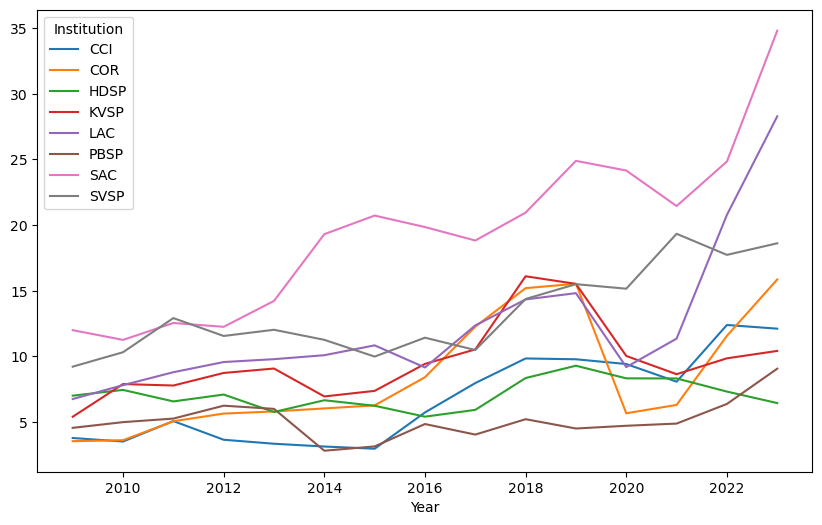

In [19]:
df_pivot.plot(figsize=(10,6))